# Fracitonal Cover <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls_usgs_fc_scene](https://explorer.digitalearth.africa/ls_usgs_fc_scene), 
[ls_usgs_wofs_scene](https://explorer.digitalearth.africa/ls_usgs_wofs_scene),
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a),
* **Prerequisites:** For more details and better understanding of the input datasets, see: [Sentinel-2](../Datasets/Sentinel-2.ipynb), [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb).


### Background

Fractional Cover (FC) product provides estimates of the proportions of green vegetation, non-green vegetation (including deciduous trees during autumn, dry grass, etc.), and bare soils for every Landsat or Sentinel-2 pixel.

This product supports a range of environemental and agricultural applications, including soil erosion monitoring, land surface process modelling, land management and vegetation studies. The information can be used by policy agencies, natural and agricultural land resource managers, and scientists to monitor land conditions over large areas over long time periods.

The algorithm is developed by the Joint Remote Sensing Research Program (JRSRP) and is described in Scarth et al. (2010). Field data collected across Australia have been used to calibrate and validate the unmixing model.

More information on the product can be found [here](http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Seasonal+Fractional+Cover).

**Reference**

Scarth, P, Roder, A and Schmidt, M 2010, 'Tracking grazing pressure and climate interaction - the role of Landsat fractional cover in time series analysis', Proceedings of the 15th Australasian Remote Sensing & Photogrammetry Conference (ARSPC), 13-17 September, Alice Springs, Australia. Alice Springs, NT.



## Description

This notebook will cover following topics:

1. Loading and visulsizing pre-generated FC data.
2. Masking FC with Water Observations from Space Feature Layer.
3. Calculating FC from Sentinel-2 surface reflectance.

To consider:
* Benefit of measureing NPV and BS over NDVI (load FC and SR timeseries)
* Long term trend for farm monitoring - (polygon drill or image seg)
* Statistics can be used to map land cover (fc percentile)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [125]:
%matplotlib inline

import datacube
from datacube.utils import masking
from fc.fractional_cover import compute_fractions

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr

sys.path.append('../Scripts')
from deafrica_plotting import rgb
from deafrica_datahandling import load_ard


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [7]:
dc = datacube.Datacube(app='fractional_cover')

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


In [127]:
lat, lon = 3.94, 41.2
buffer = 0.05

3.96, 41.64
query = {
    'time': ('2017-01', '2017-12'),
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'output_crs': 'epsg:6933',
    'resolution':(-30,30),
}

min_gooddata = 0.5

In [124]:
ls_fc

<xarray.Dataset>
Dimensions:      (time: 56, x: 322, y: 425)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-12T07:29:24.234552 ... 2017-12-30T07:29:47.531141
  * y            (y) float64 5.086e+05 5.086e+05 ... 4.959e+05 4.959e+05
  * x            (x) float64 3.97e+06 3.97e+06 3.97e+06 ... 3.98e+06 3.98e+06
    spatial_ref  int32 6933
Data variables:
    BS           (time, y, x) int16 54 59 60 48 42 46 42 ... -1 -1 -1 -1 -1 -1
    PV           (time, y, x) int16 0 0 2 8 12 10 12 12 ... -1 -1 -1 -1 -1 -1 -1
    NPV          (time, y, x) int16 46 40 37 43 45 43 44 ... -1 -1 -1 -1 -1 -1
    UE           (time, y, x) int16 5 5 5 6 7 6 7 7 ... -1 -1 -1 -1 -1 -1 -1 -1
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## Loading and visulsizing pre-generated FC data.
Use headings to break up key steps/stages of the notebook.

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

> **Note:** Use this markdown format (sparingly) to draw particular attention to an important point or caveat

In [123]:
# load all available fc data
ls_fc = dc.load(product = 'ls_usgs_fc_scene', **query)

In [17]:
# drop invalid scenes
ls_fc = ls_fc.where(ls_fc>=0).dropna('time', how='all')

In [41]:
# mask with wofs
wofl = dc.load(product='ls_usgs_wofs_scene', **query).sel(time=fc.time)
clear_and_dry = masking.make_mask(wofl, dry=True).water

In [60]:
good_slice = clear_and_dry.mean(['x','y']) > min_gooddata

In [117]:
fc_clear = ls_fc.where(clear_and_dry).isel(time=good_slice)

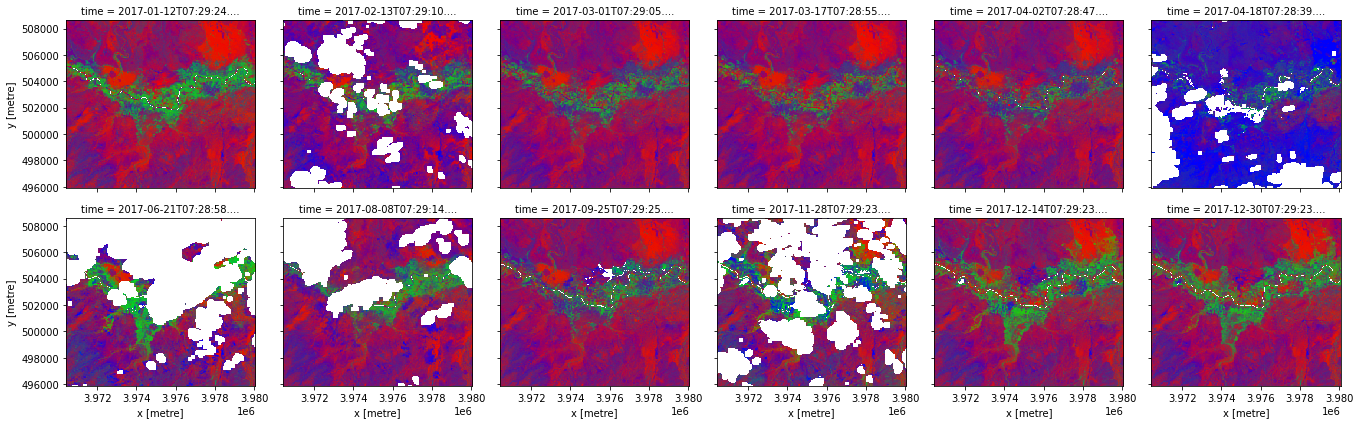

In [118]:
fc_clear[['BS','PV','NPV']].to_array().plot.imshow(col='time',col_wrap=6);

In [115]:
# apply a sum to one filter
sum_to_one = np.abs(fc_clear[['BS','PV','NPV']].to_array(dim='band').sum(dim='band', skipna=False)-100)<5

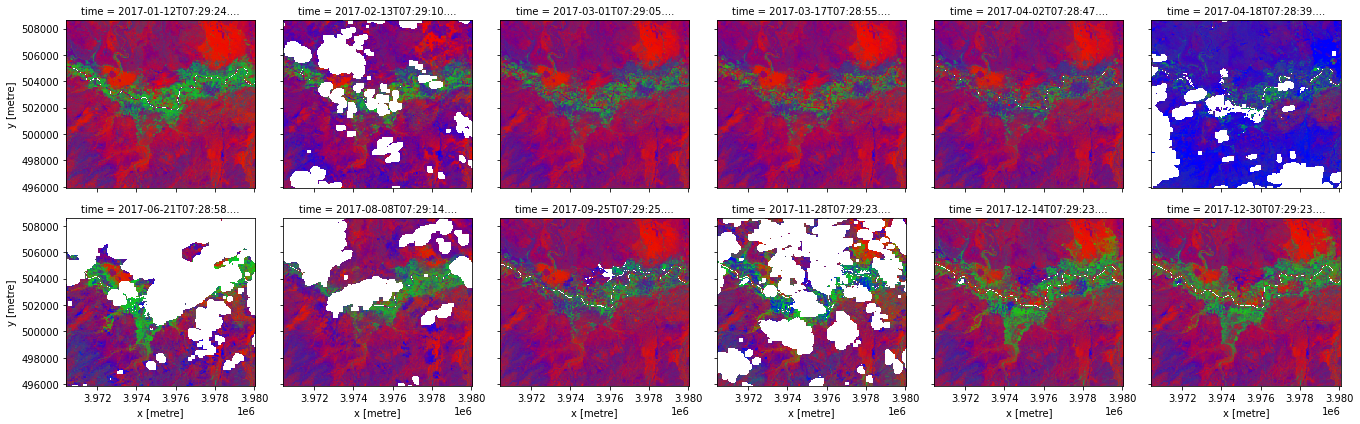

In [120]:
fc_clear.where(fc_clear.UE<25).where(sum_to_one)[['BS','PV','NPV']].to_array().plot.imshow(col='time',col_wrap=6);

### Subheading 1

Masking FC with Water Observations from Space Feature Layer.


In [ ]:
# Use code comments for low-level documentation of code
b = 2

## Masking FC with Water Observations from Space Feature Layer.
Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [ ]:
# Use code comments for low-level documentation of code
c = 3

In [131]:
# load clear sentinel-2 data

bands = ['green','red','nir','swir_1','swir_2']
s2 = load_ard(dc=dc,
              products=['s2_l2a'],
              measurements=bands,
              min_gooddata=min_gooddata,
              dask_chunks={},
              **query)


../Scripts/deafrica_datahandling.py:233: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 34 out of 52 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Returning 34 time steps as a dask array


In [ ]:
# run this in VDI to define output_measurements

from fc.fractional_cover import compute_fractions
from datacube.utils import read_documents
#from datacube.storage.masking import valid_data_mask

from pathlib import Path
from collections import OrderedDict
import xarray as xr
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr, spearmanr, kendalltau


app_config_file='/g/data/v10/public/modules/agdc-fc/fc-1.2.0-20-g3aaa2a8/config/ls8_fc_albers.yaml'
app_config_path = Path(app_config_file)
_, config = next(read_documents(app_config_path))
# required by FC: output_measurements and regression_coefficients 
var_def_keys = {'name', 'dtype', 'nodata', 'units', 'aliases', 'spectral_definition', 'flags_definition'}
measurements=[{k: v for k, v in measurement.items() if k in var_def_keys} 
              for measurement in config['measurements']]
output_measurements = OrderedDict((m['name'], m) for m in measurements).values()


In [ ]:
# calculate fc from S2

def compute_fc(input_ds, #input_nodata=-999,
               fc_bands=['green','red','nir','swir_1','swir_2'],
               regression_coefficients=None,
               output_measurements=output_measurements):
    
    band_names = ['PV', 'NPV', 'BS', 'UE']
    output_ds = xr.Dataset(coords={#'time': input_ds.time[:], 
                                'y': input_ds.y[:], 'x': input_ds.x[:],
                                'band': band_names,
                                }, attrs=input_ds.attrs)
    for time_index in range(input_ds.time.count().values):
        input_data=input_ds[fc_bands].isel(time=time_index).to_array().data
        is_valid_array= (input_data >0).all(axis=0)
        # Set nodata to 0                                                       
        input_data[:, ~is_valid_array] = 0

        # compute fractional_cover
        output_data = compute_fractions(input_data, regression_coefficients)
        
        nodata_values = {}
        for measurement in output_measurements:
            src_var = measurement.get('src_var', None) or measurement.get('name')
            i = band_names.index(src_var)
            # Set nodata value into output array
            band_nodata = np.dtype(measurement['dtype']).type(measurement['nodata'])
            compute_error = (output_data[i, :, :] == -1)
            output_data[i, compute_error] = band_nodata
            output_data[i, ~is_valid_array] = band_nodata
            #nodata_values[band_names[i]]=band_nodata

        # re-arrange bands
        output_ds[input_ds.time.values[time_index]]= (('band','y','x'), output_data)
    
    return output_ds.to_array(dim='time').to_dataset(dim='band')[['BS', 'PV', 'NPV', 'UE']]


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)